In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
import pathlib
import pandas as pd
import matplotlib.pyplot as plt

Number Of Classes    :  21
Number Of Images(Training,Validation):  9450 2100


Distribution Per Class


<AxesSubplot:>

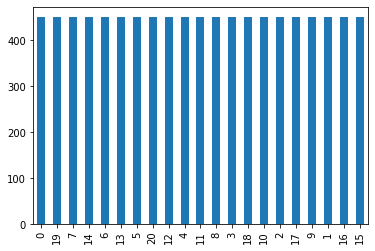

In [2]:
train_ds = pd.read_csv("../input/landuse-scene-classification/train.csv")
train_ds['Filename']=train_ds['Filename'].apply(lambda x:"train/"+x)
val_ds = pd.read_csv("../input/landuse-scene-classification/validation.csv")
val_ds['Filename']=val_ds['Filename'].apply(lambda x:"validation/"+x)
ds = pd.concat([train_ds,val_ds]).sample(frac=1).reset_index(drop=True)

n = int(len(ds))
classes = ds.Label.nunique()
print("Number Of Classes    : ",classes)
print("Number Of Images(Training,Validation): ",n,len(val_ds))
print("\n\nDistribution Per Class")
ds['Label'].value_counts().plot.bar()

In [3]:
ds.head()

,Unnamed: 0,Filename,Label,ClassName
0,1748,train/freeway/freeway_000062.png,8,freeway
1,2378,train/river/river_000464.png,15,river
2,3137,train/tenniscourt/tenniscourt_000063.png,19,tenniscourt
3,1513,train/freeway/freeway_000089.png,8,freeway
4,112,train/beach/beach_000432.png,3,beach


In [4]:
def load_img(path,fresh):
    img = tf.io.decode_jpeg(tf.io.read_file("../input/landuse-scene-classification/images_train_test_val/"+path),channels=3)
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, [224,224])
    img = keras.applications.vgg16.preprocess_input(img)
    return img,fresh

In [5]:
dataset = tf.data.Dataset.from_tensor_slices((ds.Filename.values,ds.Label.values))

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = dataset.take(int(0.8*len(ds)))
val_ds = dataset.take(int(0.2*len(ds)))

train = train_ds.map(load_img,num_parallel_calls=AUTOTUNE).batch(32).prefetch(buffer_size=AUTOTUNE)
val   = val_ds.map(load_img,num_parallel_calls=AUTOTUNE).batch(32).prefetch(buffer_size=AUTOTUNE)

In [7]:
base_model = keras.applications.VGG16(weights="imagenet",include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(classes, activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

58892288/58889256 [==============================] - 0s 0us/step


In [8]:
model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
history = model.fit(train, epochs=5, validation_data=val,verbose=1)

Epoch 1/5
237/237 [==============================] - 69s 249ms/step - loss: 3.1339 - accuracy: 0.3903 - val_loss: 0.5157 - val_accuracy: 0.8349
Epoch 2/5
237/237 [==============================] - 42s 179ms/step - loss: 0.4498 - accuracy: 0.8553 - val_loss: 0.3007 - val_accuracy: 0.9021
Epoch 3/5
237/237 [==============================] - 43s 183ms/step - loss: 0.2682 - accuracy: 0.9162 - val_loss: 0.2124 - val_accuracy: 0.9333
Epoch 4/5
237/237 [==============================] - 40s 167ms/step - loss: 0.1881 - accuracy: 0.9419 - val_loss: 0.1584 - val_accuracy: 0.9556
Epoch 5/5
237/237 [==============================] - 41s 172ms/step - loss: 0.1411 - accuracy: 0.9634 - val_loss: 0.1214 - val_accuracy: 0.9677


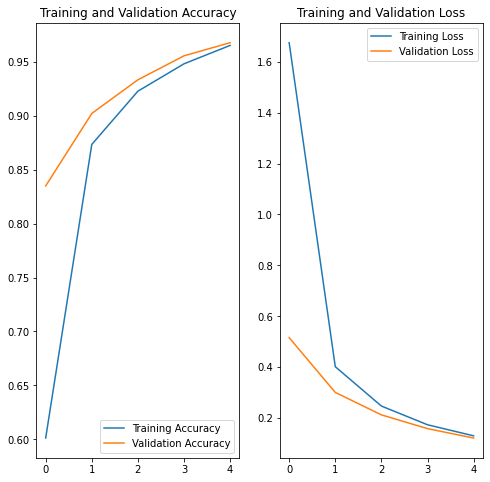

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(history.history['val_loss']))
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [10]:
test_ds = pd.read_csv("../input/landuse-scene-classification/test.csv")
test_ds['Filename']=test_ds['Filename'].apply(lambda x:"test/"+x)

test_x = tf.data.Dataset.from_tensor_slices((test_ds.Filename.values,test_ds.Label.values))
test_x = test_x.map(load_img).batch(32)

score = model.evaluate(test_x, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.226663738489151
Test accuracy: 0.9285714030265808


In [11]:
model.save("land_classifier.h5")